### Begin to clean and explore your data.

In [1]:
### Install 
!pip install category-encoders
!pip install pdpbox

  Using cached category_encoders-2.2.2-py2.py3-none-any.whl (80 kB)
     |████████████████████████████████| 231 kB 3.5 MB/s eta 0:00:01
     |████████████████████████████████| 9.5 MB 14.8 MB/s eta 0:00:01
  Using cached PDPbox-0.2.0.tar.gz (57.7 MB)
     |████████████████████████████████| 8.5 MB 4.9 MB/s eta 0:00:01     |███████████████████████████▋    | 7.3 MB 4.9 MB/s eta 0:00:01
  Using cached psutil-5.8.0-cp38-cp38-macosx_10_9_x86_64.whl (236 kB)
     |████████████████████████████████| 2.2 MB 2.8 MB/s eta 0:00:01
     |████████████████████████████████| 61 kB 163 kB/s eta 0:00:01
  Created wheel for pdpbox: filename=PDPbox-0.2.0-py3-none-any.whl size=57690721 sha256=3abbd3296b080a9abfa47442aa0cd9f673c19f345a5da0a3760c080598ca7cf9
  Stored in directory: /Users/hillarykhan/Library/Caches/pip/wheels/7f/7d/f5/136844ad90a5cfb60b92f6de7afadd0574042b6012a6d16e2b
Successfully built pdpbox


In [2]:
### Import libraries

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

from category_encoders import OrdinalEncoder, BinaryEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest

from sklearn.metrics import auc, f1_score, classification_report
from sklearn.metrics import plot_confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.inspection import permutation_importance

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [5]:
### Read in data
pd.options.display.max_columns = None
data_path = '../LS_Unit2_Build/'

def wrangle(filepath):
    df = pd.read_csv(filepath,
                     parse_dates = ['CP Date of Birth', 'Date First Office', 'Date FEPA Sent to EEOC',
                              'Closure Date', 'Court Filing Date', 'Litigation Resolution Date'],
                     thousands=',',
                     index_col = 'Date First Office').sort_index()

    ## Some dates parsed incorrectly (e.g. year is 2066 instead of 1966)

    def fix_date(x):

        if x.year >= 2009:
            year = x.year - 100
        else:
            return x 

        return dt.date(year, x.month, x.day)

    df['CP Date of Birth'] = df['CP Date of Birth'].apply(fix_date)
    

    ## Feature Engineering
    ##     Age at time of filing
    df['age'] = round((df.index - df['CP Date of Birth']).dt.days / 365)

    ##     Appx Length of investigation
    df['investigation_duration'] = (df['Closure Date'] - df.index).dt.days
    
    ## Pull industry code from NAICS Code:
    df['NAICS Code'] = df['NAICS Code'].astype(str)
    df['NAICS Code'] = df['NAICS Code'].str[0:2]

    ## Split basis into (general) basis and basis_specific
    df[['Basis', 'Basis_Specific']] = df['Basis'].str.split('-', 1, expand=True)
    df.loc[(df.Basis == 'Equal Pay'),'Basis']='Sex'
    df['Basis_Specific'].fillna(df['Basis'], inplace=True)
    social = ['Retaliation', 'Race', 'Sex', 'Age', 'National Origin', 
              'Religion', 'Color', 'Post', 'Relationship/Assn.',
              'Sexual Orientation', 'Ancestry', 'Conviction Record', 'Marital Status']
    
    neurological = ['Other Neurological', 'Epilepsy', 'Paralysis', 'Multiple Sclerosis',
                    'Cerebral Palsy', 'Autism', 'Intellectual Disability', 'Learning Disability',
                    'Brain/Head Impairment', 'Alzheimers']
    
    psychiatric = ['Other Psychiatric Disorders','Schizophrenia', 'Manic Depression (Bi',
                   'Depression', 'Alcoholism', 'Drug Addiction', 'Other Anxiety Disorder']
    
    physical = ['Hearing Impairment', 'Speech Impairment', 'Vision Impairment',
                'Nonparalytic Orthopedic Impairment', 'Orthopedic/Structural Back Impairment',
                'Handicap (Not ADA)', 'Missing Digits/Limbs', 'Brain/Head Injury (Traumatic)', 'Disfigurement', 
                'Heart/Cardiovascular', 'Kidney Impairment', 'Cancer', 'Chemical Sensitivity', 'Diabetes',                               
                'Gastrointestinal', 'Blood (Other)', 'HIV', 
                'Cumulative Trauma Disorder', 'Other Pulmo/Respiratory', 'Allergies', 'Asthma', 'Cystic Fibrosis',
                'Dwarfism ','Tuberculosis']
    genetic = ['Genetic Information Discrimination', 'Genetic Testing', 'Genetic Discrimination']
    other = ['Other Disability', 'Record Of Disability', 'Regarded As Disabled']
    def rebasis(val):
        if val in neurological:
            return 'Neurological Disability'
        if val in psychiatric:
            return 'Psychiatric Disability'
        if val in physical:
            return 'Physical Disability'
        if val in genetic:
            return 'Genetics'
        if val in other:
            return 'Other Disability'
        if val in social:
            return val
        return 'Other'
    df['Basis'] = df['Basis'].apply(rebasis)
    
    # Turn Monetary Benefits into binary for whether or not benefits received
    df['Monetary Benefits'] = (df['Monetary Benefits'] > 0).astype(int)
    
    ## Use closure type to create the target, then drop closure type
    no = ['No Cause Finding Issued','NRTS Issued At CP Request', 'Settlement With Benefits',
                  'Withdrawal With Benefits', 'No Jurisdiction', 'CP Withdrawal - No Ben.',
                  'Administrative Closure', 'CP Filed Suit', 'ADEA Sect. 7(D) Closure',
                  'Closed Due To Court Decision']
    yes = ['Conciliation Failure', 'Successful Conciliation','Respondent Bankruptcy'] 

    def reclass(val):
        if val in no:
            return 0
        if val in yes:
            return 1
        return 99

    df['decision'] = df['Closure Type'].apply(reclass)
    
    # need to drop rows with NaN in 'Closure Type'
    # there are 113,813 rows with no closure type - unclear why
    df = df.dropna(axis = 0, subset=['Closure Type'])
    df.drop(columns='Closure Type', inplace=True)

    df['Closure Date'] = df['Closure Date'].map(dt.datetime.toordinal)
    
    ## Impute categorical missing values:
    most_freq_state = df['State Code'].value_counts().index[0]
    df['State Code'].fillna(most_freq_state, inplace=True) #TX
    df['No of Employees'].fillna('Unknown', inplace=True)
    df['NAICS Description'].fillna('Unknown', inplace=True)
    df['CP Sex'].fillna('Unknown', inplace=True)
    df['Statute'].fillna('Other', inplace=True)
    most_freq_inst_type = df['Institution Type'].value_counts().index[0]
    df['Institution Type'].fillna(most_freq_inst_type, inplace=True) #Private Employer

    ## Drop columns with too many missing values
    df = df.dropna(axis=1, thresh=100_000) 
    
    ## Drop redundant features
    df = df.drop(columns=['Unique ID', 'No of Employees Code', 'Institution Type Code', 
                          'Closure Code', 'Statute Code', 'Basis Code', 'Issue Code', 'CP Date of Birth'])
    ##Drop high-cardinality
    df = df.drop(columns=['NAICS Description'])
    
    return df


In [6]:
df = wrangle(data_path + 'buildweek/unit2build.csv')

In [7]:
df.dtypes

State Code                 object
No of Employees            object
NAICS Code                 object
Institution Type           object
CP Sex                     object
Closure Date                int64
Monetary Benefits           int64
Statute                    object
Basis                      object
Issue                      object
age                       float64
investigation_duration    float64
Basis_Specific             object
decision                    int64
dtype: object

In [8]:
df.head()

,State Code,No of Employees,NAICS Code,Institution Type,CP Sex,Closure Date,Monetary Benefits,Statute,Basis,Issue,age,investigation_duration,Basis_Specific,decision
Date First Office,,,,,,,,,,,,,,
2009-10-01,KS,Unknown,72,Private Employer,N,733828,0,ADEA,Retaliation,Constructive Discharge,58.0,147.0,Retaliation,0
2009-10-01,AZ,501+ Employees,72,Private Employer,M,733724,0,ADEA,Age,Hiring,61.0,43.0,Age,0
2009-10-01,AZ,501+ Employees,72,Private Employer,M,733724,0,ADEA,Age,Discharge,61.0,43.0,Age,0
2009-10-01,AR,15 - 100 Employees,na,Private Employer,F,733721,0,ADA,Retaliation,Discharge,45.0,40.0,Retaliation,0
2009-10-01,AR,15 - 100 Employees,na,Private Employer,F,733721,0,ADA,Retaliation,Harassment,45.0,40.0,Retaliation,0


In [9]:
df.shape

(230050, 14)

Possible Classes:

- 0 - No discrimination
- 1 - Discrimination

Original Classes:
- No Cause Finding Issued           0
- NRTS Issued At CP Request         2*  
- Settlement With Benefits          2
- Withdrawal With Benefits          2
- No Jurisdiction                   2
- CP Withdrawal - No Ben.           2
- Administrative Closure            2
- Conciliation Failure              1 
- CP Filed Suit                     2
- Successful Conciliation           1
- ADEA Sect. 7(D) Closure           2
- Respondent Bankruptcy             1
- Closed Due To Court Decision      2*


**Only 'conciliation' is preceded by reasonable cause determined by the EEOC**


In [10]:
df['decision'].value_counts(normalize=True)

0    0.987264
1    0.012736
Name: decision, dtype: float64

# Module 3

For moderately-highly imbalanced data it is recommmended to use precision-recall curves to avoid an 'overly optimistic' ROC curve and misleading roc-auc scores. This may also explain the higher roc_auc score above.

Also, when using precision-recall curves, we can use PR AUC scores instead. The difference between PR AUC is that it looks at the positive predictive value and true positive rate (rather than the true positive and false positive rates). Because the positive class of my dataset, 'cause-found' for discrimination, is also very small (~1%) it may be better to use the PR AUC than the ROC AUC.

- https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
- https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/#:~:text=ROC%20Curves%20summarize%20the%20trade,model%20using%20different%20probability%20thresholds.&text=ROC%20curves%20are%20appropriate%20when,are%20appropriate%20for%20imbalanced%20datasets.
- https://www.kaggle.com/lct14558/imbalanced-data-why-you-should-not-use-roc-curve
- https://medium.com/data-science-in-your-pocket/calculating-precision-recall-for-multi-class-classification-9055931ee229
- http://www.davidsbatista.net/blog/2018/08/19/NLP_Metrics/
- https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc

### Split the data (train, val, test)

In [11]:
# Create feature matrix and target vector
target = 'decision'
y = df[target]
X = df.drop(columns=target)

In [12]:
# Split data into train, validation, and test sets

cutoff1 = int(len(df)*0.6)
cutoff2 = int(len(df)*0.8)

X_train, y_train = X.iloc[0:cutoff1], y.iloc[0:cutoff1]
X_val, y_val = X.iloc[cutoff1:cutoff2], y.iloc[cutoff1:cutoff2]
X_test, y_test = X.iloc[cutoff2:], y.iloc[cutoff2:]

assert len(X_train) + len(X_val) + len(X_test) == len(X)

### Set the baseline: Precision Recall AUC score

In [13]:
# "A no-skill model is represented by a horizontal line with a precision 
# that is the ratio of positive examples in the dataset 
# (e.g. TP / (TP + TN))""
# https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/

print('Baseline Precision-Recall AUC score: {0:0.4f}'.format(y.value_counts(normalize=True)[1]))

Baseline Precision-Recall AUC score: 0.0127


### Base Model - Logistic Regression

**Preprocessing**

In [14]:
num_cols = X.select_dtypes(exclude='object').columns
ord_cat_cols = ['No of Employees']
nom_cat_cols = ['State Code', 'NAICS Code','Institution Type', 'CP Sex', 
                'Statute', 'Basis', 'Basis_Specific', 'Monetary Benefits', 
                'Issue'] 

num_transformers = make_pipeline(SimpleImputer(),
                                 StandardScaler())
ord_cat_transformers = OrdinalEncoder()
nom_cat_transformers = BinaryEncoder()

In [15]:
preprocessing = ColumnTransformer(transformers = [
    ('num', num_transformers, num_cols),
    ('ord', ord_cat_transformers, ord_cat_cols),
    ('nom', nom_cat_transformers, nom_cat_cols)])

**Fit Logistic Regression Model with Training Data**

In [16]:
model_log = make_pipeline(preprocessing,
                         LogisticRegression())
model_log.fit(X_train, y_train);

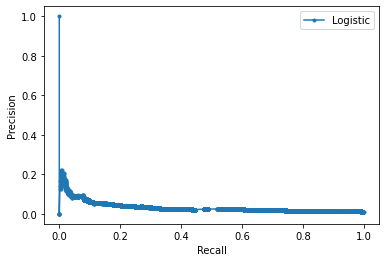

Logistic: f1=0.498 auc=0.033


In [17]:
log_probs = model_log.predict_proba(X_val)
log_probs = log_probs[:, 1]
log_precision, log_recall, _ = precision_recall_curve(y_val, log_probs)

plt.plot(log_recall, log_precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

log_pred = model_log.predict(X_val)

log_f1, log_auc = f1_score(y_val, log_pred, average='macro'), auc(log_recall, log_precision)
print('Logistic: f1=%.3f auc=%.3f' % (log_f1, log_auc))


**Tuning: Logistic Regression**

In [18]:
model_logb = make_pipeline(preprocessing,
                           SelectKBest(k=6),
                           LogisticRegression(C=5,
                                              solver='newton-cg'))
# params = {
#     'selectkbest__k': range(5, 13, 1),
#     'logisticregression__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
#     'logisticregression__class_weight': [None, 'balanced'],
#     'logisticregression__C': [0.01, 0.1, 1, 5, 10]
# }

# model_gs = GridSearchCV(
#     estimator=model_logb,
#     param_grid=params,
#     scoring = 'f1_macro',
#     cv=5,
#     n_jobs=-1,
#     verbose=1
# )

# model_gs.fit(X_train, y_train);
# model_gs.best_estimator_

In [19]:
model_logb.fit(X_train, y_train);

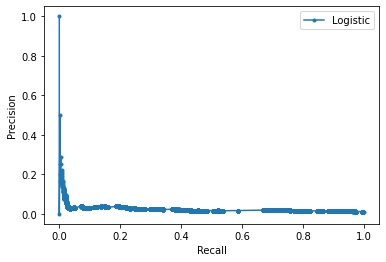

Logistic: f1=0.498 auc=0.025


In [20]:
# Check evaluation metric
logb_probs = model_logb.predict_proba(X_val)
logb_probs = logb_probs[:, 1]
logb_precision, logb_recall, _ = precision_recall_curve(y_val, logb_probs)

plt.plot(logb_recall, logb_precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

logb_pred = model_logb.predict(X_val)

logb_f1, logb_auc = f1_score(y_val, logb_pred, average='macro'), auc(logb_recall, logb_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (logb_f1, logb_auc))


In [21]:
model_log2 = make_pipeline(preprocessing,
                           LogisticRegression(class_weight = 'balanced'))
model_log2.fit(X_train, y_train);

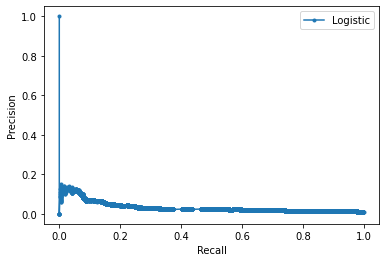

Logistic: f1=0.443 auc=0.034


In [22]:
log2_probs = model_log2.predict_proba(X_val)
log2_probs = log2_probs[:, 1]
log2_precision, log2_recall, _ = precision_recall_curve(y_val, log2_probs)

plt.plot(log2_recall, log2_precision, marker='.', label='Logistic')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

log2_pred = model_log2.predict(X_val)

log2_f1, log2_auc = f1_score(y_val, log2_pred, average='macro'), auc(log2_recall, log2_precision)
print('Logistic: f1=%.3f auc=%.3f' % (log2_f1, log2_auc))


### Bagging Model - Random Forest

In [23]:
model_rf = make_pipeline(preprocessing,
                         RandomForestClassifier())

model_rf.fit(X_train, y_train);

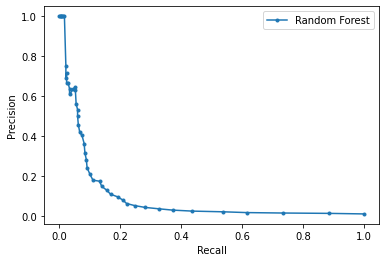

Random Forest: f1=0.503 auc=0.091


In [24]:
rf_probs = model_rf.predict_proba(X_val)
rf_probs = rf_probs[:, 1]
rf_precision, rf_recall, _ = precision_recall_curve(y_val, rf_probs)

plt.plot(rf_recall, rf_precision, marker='.', label='Random Forest')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

rf_pred = model_rf.predict(X_val)

rf_f1, rf_auc = f1_score(y_val, rf_pred, average='macro'), auc(rf_recall, rf_precision)
print('Random Forest: f1=%.3f auc=%.3f' % (rf_f1, rf_auc))

In [25]:
# params = {
#     'randomforestclassifier__max_depth': [70, 100, 125],
#     'randomforestclassifier__min_samples_leaf': [10, 15, 20],
#     'randomforestclassifier__max_features': [9, 10, 11]
# }

# model_gs = GridSearchCV(
#     estimator=model_rf2,
#     param_grid=params,
#     scoring = 'f1_macro',
#     cv=5,
#     n_jobs=-1,
#     verbose=1
# )

# model_gs.fit(X_train, y_train);

In [26]:
# model_gs.best_estimator_

### Classification Reports

In [27]:
target_names = ['No', 'Yes']
y_test_log = model_log.predict(X_test)
log_class_report = classification_report(y_test, y_test_log, target_names=target_names)
print('Base Model: \n', log_class_report)

y_test_rf = model_rf.predict(X_val)
rf_class_report = classification_report(y_val, y_test_rf, target_names=target_names)
print('RandomForest on validation: \n', rf_class_report)

y_test_rf = model_rf.predict(X_test)
rf_class_report = classification_report(y_test, y_test_rf, target_names=target_names)
print('RandomForest on test: \n', rf_class_report)

Base Model: 
               precision    recall  f1-score   support

          No       1.00      1.00      1.00     45864
         Yes       0.00      0.00      0.00       146

    accuracy                           1.00     46010
   macro avg       0.50      0.50      0.50     46010
weighted avg       0.99      1.00      1.00     46010

RandomForest on validation: 
               precision    recall  f1-score   support

          No       0.99      1.00      1.00     45594
         Yes       1.00      0.00      0.01       416

    accuracy                           0.99     46010
   macro avg       1.00      0.50      0.50     46010
weighted avg       0.99      0.99      0.99     46010

RandomForest on test: 
               precision    recall  f1-score   support

          No       1.00      1.00      1.00     45864
         Yes       0.00      0.00      0.00       146

    accuracy                           1.00     46010
   macro avg       0.50      0.50      0.50     46010
weight

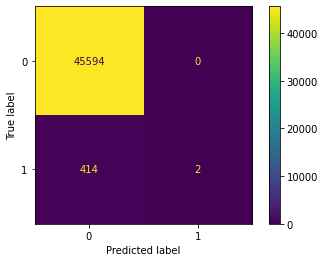

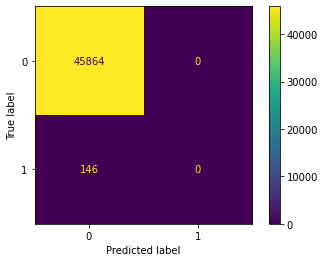

In [28]:
plot_confusion_matrix(model_rf, X_val, y_val)
plot_confusion_matrix(model_rf, X_test, y_test)

**Permutation Importances**

In [29]:
# Permutation Importances

perm_imp = permutation_importance(model_rf,
                                  X_val,
                                  y_val,
                                  n_jobs=-1)
perm_imp

{'importances_mean': array([4.78156922e-05, 4.78156922e-05, 8.69376223e-06, 1.30406433e-05,
        1.30406433e-05, 4.34688111e-05, 0.00000000e+00, 1.73875245e-05,
        3.91219300e-05, 4.78156922e-05, 1.73875245e-05, 0.00000000e+00,
        3.91219300e-05]),
 'importances_std': array([8.69376223e-06, 1.62645398e-05, 1.73875245e-05, 1.73875245e-05,
        2.21648316e-05, 0.00000000e+00, 0.00000000e+00, 1.62645398e-05,
        8.69376223e-06, 8.69376223e-06, 8.69376223e-06, 1.37460450e-05,
        8.69376223e-06]),
 'importances': array([[ 4.34688111e-05,  4.34688111e-05,  6.52032167e-05,
          4.34688111e-05,  4.34688111e-05],
        [ 4.34688111e-05,  6.52032167e-05,  2.17344056e-05,
          4.34688111e-05,  6.52032167e-05],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  4.34688111e-05],
        [ 4.34688111e-05,  2.17344056e-05,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [-2.17344056e-05,  4.34688111e-05,  0.

In [30]:
pi_data = pd.DataFrame({'importances_mean':perm_imp['importances_mean'],
                       'importances_std': perm_imp['importances_std']},
                      index=X_val.columns)
pi_data

,importances_mean,importances_std
State Code,0.000048,0.000009
No of Employees,0.000048,0.000016
NAICS Code,0.000009,0.000017
Institution Type,0.000013,0.000017
CP Sex,0.000013,0.000022
Closure Date,0.000043,0.000000
Monetary Benefits,0.000000,0.000000
Statute,0.000017,0.000016
Basis,0.000039,0.000009
Issue,0.000048,0.000009


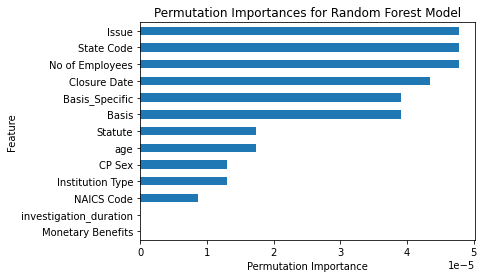

In [31]:
pi_data['importances_mean'].sort_values().plot(kind='barh')
plt.xlabel('Permutation Importance')
plt.ylabel('Feature')
plt.title('Permutation Importances for Random Forest Model');

### Partial Dependence Plots

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <AxesSubplot:>, 'pdp_ax': <AxesSubplot:xlabel='Closure Date'>})

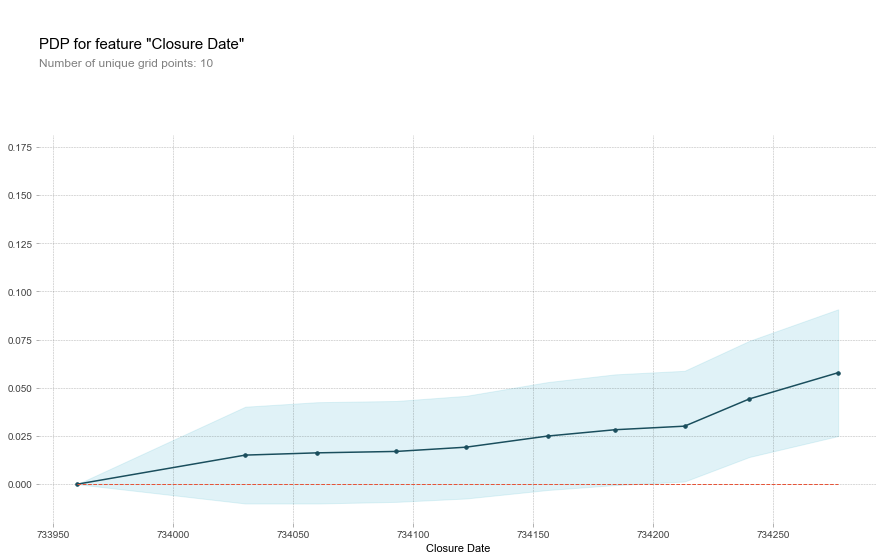

In [32]:
feature = 'Closure Date'
isolate = pdp_isolate(model=model_rf,
                      dataset=X_test,
                      model_features=X_test.columns,
                      feature=feature
)

pdp_plot(isolate,
        feature_name=feature)

In [33]:
# X_test_enc = OrdinalEncoder().fit_transform(X_test)


# feature = ['State Code', 'Closure Date']
# interact = pdp_interact(model=model_rf,
#                       dataset=X_test_enc,
#                       model_features=X_test_enc.columns,
#                       features=feature
# )

# pdp_interact_plot(interact, plot_type='grid',
#                   feature_names=feature)